<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">


# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Análise Exploratória de Dados de Logística(Loggi)**

## 1\. Contexto

Com as informações extraidas do portifolio **Loggi Benchmark for Urban Deliveries (BUD)** da **Startup Loggi**, notou-se uma variação significativa na densidade demográfica entre as três regiões atendidas. Esse fato despertou interesse em compreender melhor o impacto dessa variação na eficiência operacional da **Loggi**, especialmente no **Distrito Federal**.

A **análise** envolveu uma avaliação detalhada dos dados fornecidos pela **Loggi**, incluindo **visualizações gráficas** e **insights** específicos para o **Distrito Federal**.

## 2\. Pacotes e bibliotecas

In [24]:
# Instalando e importando todas as bibliotecas utilizadas no projeto
!pip3 install geopandas

import json
import pandas as pd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
# downloads dos arquivos
!wget -q 'https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip' -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

/bin/bash: line 1: cp./maps/LIM_Unidade_Federacao_A.shp: No such file or directory


## 3\. Exploração de dados

O dado bruto é um arquivo do tipo `.json` com uma lista de instâncias de entregas logísticas. Vamos extrair as informações e transformar em um **DataFrame** do **pandas** para facilitar a manipulação .

In [48]:
# dado bruto em um dict
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

# Transformando o dict python em um DataFrame do pandas
deliveries_df = pd.DataFrame(data)

# Visualizando o DataFrame deliveries_df
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Como pôde-se observar, há dados aninhados nas colunas "origin", vamos normalizar a coluna com uma operação conhecida como `flatten` ou achatamento, que transforma cada chave do `json` em uma nova coluna:

In [49]:
# Normalizando a coluna origin
hub_origin_df = pd.json_normalize(deliveries_df['origin'])

# Visualização da coluna
hub_origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


Como o novo DataFrame gerado, podemos juntar ao DataFrame original pelo index e então excluir a coluna "origin" original.

In [50]:
# Junção dos DataFrames com o método merge do pandas por um inner join através dos index
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)

# Excluindo a coluna "origin" original
deliveries_df = deliveries_df.drop('origin', axis=1)

# Ordenando e renomeando as novas colunas do DataFrame
deliveries_df = deliveries_df[['name', 'region', 'lng', 'lat', 'vehicle_capacity', 'deliveries']]
deliveries_df.rename(columns={'lng': 'hub_lng', 'lat': 'hub_lat'}, inplace=True)

# Visualização
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Nota-se que ainda há dados aninhados em diferentes níveis na coluna "deliveries", nesse caso, utilizaremos o método "explode", que gera para cada registro, uma nova linha mantendo o indice original, após isso, separar as informações em colunas e dataframes novos.

In [51]:
# Aplicando o método "explode" à coluna "deliveries"
deliveries_exploded_df = deliveries_df[['deliveries']].explode('deliveries')

deliveries_exploded_df.head(20)

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."
0,"{'id': '71271df40c3188cda88266f9969a5a9', 'poi..."
0,"{'id': 'be0cd4bee278b16f3473c8fb05e96464', 'po..."
0,"{'id': 'e0fffb7150a2a202adb36e3f2fd5cc96', 'po..."
0,"{'id': '489efb8015b9b9e208d33abae808df23', 'po..."
0,"{'id': 'f4245aa5a08f39b615cfd57a117325ec', 'po..."


In [52]:
# Concatenando as informações em um único DataFrame
deliveries_normalized_df = pd.concat([
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['size'] )).rename(columns={'deliveries': 'delivery_size'}),
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['point']['lng'] )).rename(columns={'deliveries': 'delivery_lng'}),
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['point']['lat'] )).rename(columns={'deliveries': 'delivery_lat'}),
], axis= 1)

deliveries_normalized_df.head(10)

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055
0,10,-48.120448,-15.847780
0,7,-48.121802,-15.852089
0,10,-48.116300,-15.851215
0,9,-48.116317,-15.849660
0,8,-48.123115,-15.849925


In [53]:
# Excluindo a coluna "deliveries" original
deliveries_df = deliveries_df.drop('deliveries', axis=1)

# Junção do novo DataFrame deliveries_normalized_df com o DataFrame original deliveries_df pelo index
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


Agora, com os dados estruturados em um DataFrame, partiremos para **análise exploratória** e **limpeza dos dados**.

In [55]:
# Ver as dimensões do DF
deliveries_df.shape

(636149, 8)

In [56]:
# Verificar os tipos de dados e as colunas.
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


In [57]:
# Identificar valores nulos
deliveries_df.isna().sum()

name                0
region              0
hub_lng             0
hub_lat             0
vehicle_capacity    0
delivery_size       0
delivery_lng        0
delivery_lat        0
dtype: int64

In [58]:
# Contar valores distintos nas colunas.
deliveries_df.nunique()

name                   199
region                   3
hub_lng                  3
hub_lat                  3
vehicle_capacity         1
delivery_size           10
delivery_lng        291566
delivery_lat        291566
dtype: int64

**Observação**> Existem três regiões principais de HUB's, sendo que a região mais associada às entregas é o df-1, com um total de 304.708 registros.

In [59]:
# Separar os dados numéricos
var_numericos = []

for coluna in deliveries_df.columns:
  if deliveries_df[coluna].dtype != 'object':
    var_numericos.append(coluna)

# Visualizar um resumo estatístico dos dados numéricos.
deliveries_df[var_numericos].describe().T

,count,mean,std,min,25%,50%,75%,max
hub_lng,636149.0,-47.949902,0.091875,-48.054989,-48.054989,-47.893662,-47.893662,-47.802665
hub_lat,636149.0,-15.802359,0.053463,-15.838145,-15.838145,-15.805118,-15.805118,-15.657014
vehicle_capacity,636149.0,180.000000,0.000000,180.000000,180.000000,180.000000,180.000000,180.000000
delivery_size,636149.0,5.512111,2.874557,1.000000,3.000000,6.000000,8.000000,10.000000
delivery_lng,636149.0,-47.946087,0.112769,-48.280779,-48.035911,-47.928967,-47.883394,-47.310611
delivery_lat,636149.0,-15.809492,0.082462,-16.050028,-15.842795,-15.814033,-15.769516,-15.500355


**Observação**> É evidente que os dados na coluna "**vehicle_capacity**" não apresentam variação, pois todos os valores são constantes, fixados em '**180**'. Em contraste, os valores na coluna '**delivery_size**' revelam uma variação moderada nos volumes, com uma média de **5.5121** e uma mediana de **6.0000**. O desvio padrão de **2.8746** indica variações relativamente moderadas, o que é consistente com a baixa amplitude observada nos dados.

## 4\. Manipulação

Vamos geocodificar as respectiva coodernada geográfica (latitude e longitude).

In [60]:
hub_df = deliveries_df[['region', 'hub_lng', 'hub_lat']]
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index( drop=True )

# Operação de geocodificação utilizando a API Nominatim
geolocator = Nominatim(user_agent='ebac_geocoder')
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

# Aplicando a geocodificação nas coordenadas das três regiões e extrair informações de "cidade" e "bairro"
hub_df['coordinates'] = hub_df['hub_lat'].astype(str) + ' , ' +  hub_df['hub_lng'].astype(str)
hub_df['geodata'] = hub_df['coordinates'].apply(geocoder)

hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248 , -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334 , -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274 , -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [61]:
hub_geodata_df = pd.json_normalize(hub_df['geodata'].apply(lambda data: data.raw ))

hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053343,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-127,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.100010,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000010,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [62]:
hub_geodata_df = hub_geodata_df[['address.town', 'address.suburb', 'address.city']]
hub_geodata_df.rename(columns={'address.town': 'hub_town', 'address.suburb': 'hub_suburb', 'address.city': 'hub_city'}, inplace=True)

# Preenche os valores nulos
hub_geodata_df.loc[:, 'hub_city'] = np.where(hub_geodata_df['hub_city'].notna(), hub_geodata_df['hub_city'], hub_geodata_df['hub_town'])
hub_geodata_df.loc[:, 'hub_suburb'] = np.where(hub_geodata_df['hub_suburb'].notna(), hub_geodata_df['hub_suburb'], hub_geodata_df['hub_city'])
hub_geodata_df = hub_geodata_df.drop('hub_town', axis=1)

hub_geodata_df.head()

<ipython-input-62-f9df529bd6f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename(columns={'address.town': 'hub_town', 'address.suburb': 'hub_suburb', 'address.city': 'hub_city'}, inplace=True)


,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


Agora, vamos enriquecer o Dataframe original `deliveries_df` combinando com o DataFrame `hub_geodata_df`, que contém informações adicionais sobre cidade e bairro.

In [63]:
# Mescla hub_df e hub_geodata_df e seleciona apenas as colunas "hub_suburb" e "hub_city"
hub_df = pd.merge(left=hub_df, right=hub_geodata_df[['hub_suburb', 'hub_city']], left_index=True, right_index=True)

# Mescla deliveries_df e hub_df com base na coluna "region" e seleciona as colunas desejadas
deliveries_df = pd.merge(left=deliveries_df, right=hub_df[['region', 'hub_suburb', 'hub_city']], how='inner', on='region')

# Seleciona as colunas em deliveries_df
deliveries_df = deliveries_df[['name', 'region', 'hub_lng', 'hub_lat', 'hub_city', 'hub_suburb', 'vehicle_capacity', 'delivery_size', 'delivery_lng', 'delivery_lat']]

deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


* **Geocodificação reversa da entrega**

In [64]:
# Esse arquivo contém informações adicionais sobre a cidade e o subúrbio de cada entrega

deliveries_geodata_df = pd.read_csv('deliveries-geodata.csv')
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[['delivery_city', 'delivery_suburb']], how='inner', left_index=True, right_index=True )

deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


Utilizaremos o pacote do Python GeopPandas para visualizar as coordenadas dos hubs e das entregas no mapa do Distrito Federal, segmentados pela região dos hubs

* **Mapa dos Hubs**

In [65]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = gpd.GeoDataFrame(hub_df, geometry=gpd.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
if geo_hub_df.crs is None:
    geo_hub_df.crs = 'EPSG:4326'
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


* **Mapa das entregas**

In [66]:
geo_deliveries_df = gpd.GeoDataFrame(deliveries_df, geometry=gpd.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
if geo_deliveries_df.crs is None:
    geo_deliveries_df.crs = 'EPSG:4326'
geo_deliveries_df = geo_deliveries_df.to_crs(epsg=4326)
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


* **Mapa do Distrito Federal**

In [67]:
mapa = gpd.read_file('distrito-federal.shp')
mapa = mapa.loc[[0]]

mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


## 5\. Visualização

<ipython-input-68-3912da25e9b7>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


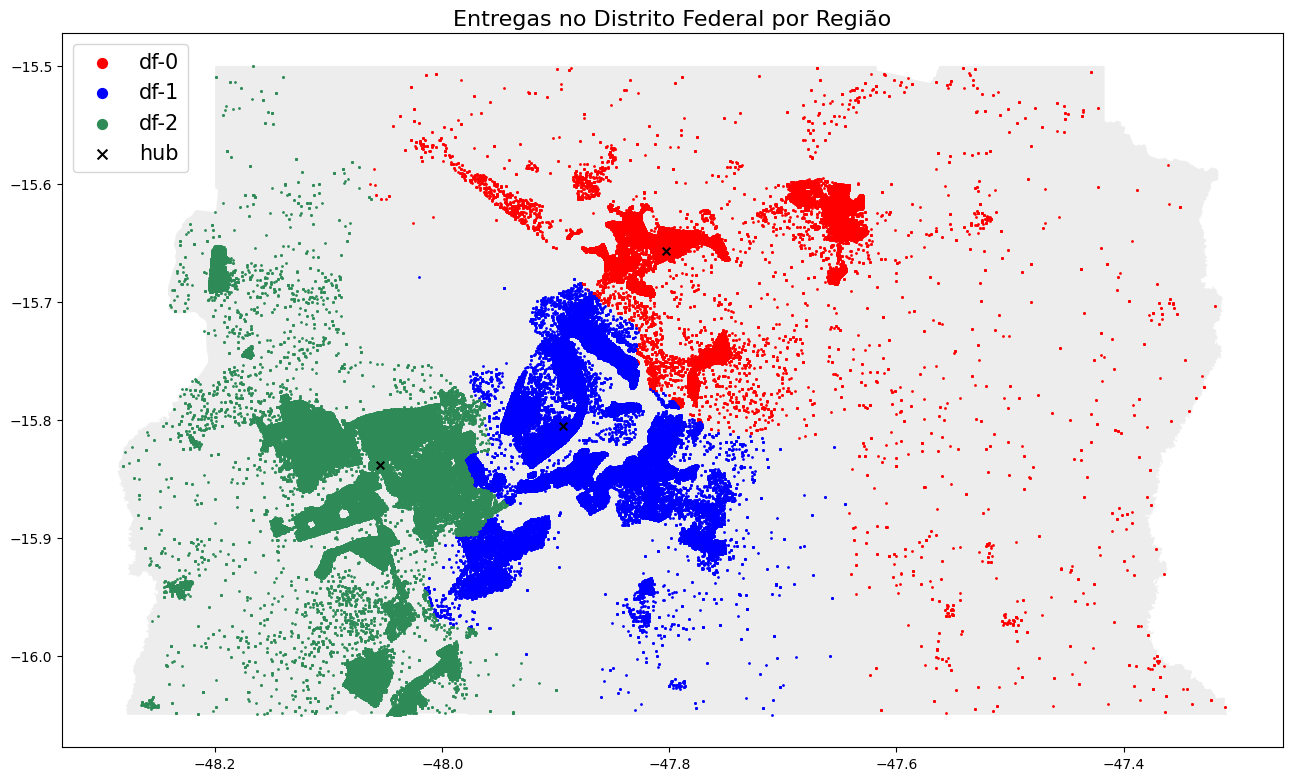

In [68]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (40/2.54, 40/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color='lightgrey')

# plot das entregas
geo_deliveries_df.query('region == "df-0"').plot( ax=ax, markersize=1, color='red', label='df-0')
geo_deliveries_df.query('region == "df-1"').plot( ax=ax, markersize=1, color='blue', label='df-1')
geo_deliveries_df.query('region == "df-2"').plot( ax=ax, markersize=1, color='seagreen', label='df-2')

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker='x', color='black', label='hub')

# plot da legenda
plt.title('Entregas no Distrito Federal por Região', fontdict={'fontsize': 16} )
lgnd = plt.legend(prop={'size': 15})
for handle in lgnd.legendHandles:
  handle.set_sizes([50])

**Insights**:

*  Analisando o gráfico, nota-se que algumas Regiões Administrativas (RAs) ainda não são atendidas de forma abrangente pelos HUB's, indicando uma oportunidade de expansão para alcançar essas áreas e aumentar a cobertura do serviço de entrega. Além disso, percebemos uma diferença significativa na distribuição geográfica da atividade dos HUB's. Enquanto o HUB DF-1 opera em uma área mais concentrada, os HUB's DF-0 e DF-2 abrangem uma área mais ampla. Isso sugere que os custos operacionais, especialmente relacionados ao combustível e logística de transporte, podem ser mais elevados para os HUB's DF-0 e DF-2, devido à necessidade de cobrir uma área geograficamente mais dispersa.

Calcular a proporção de entregas por região:


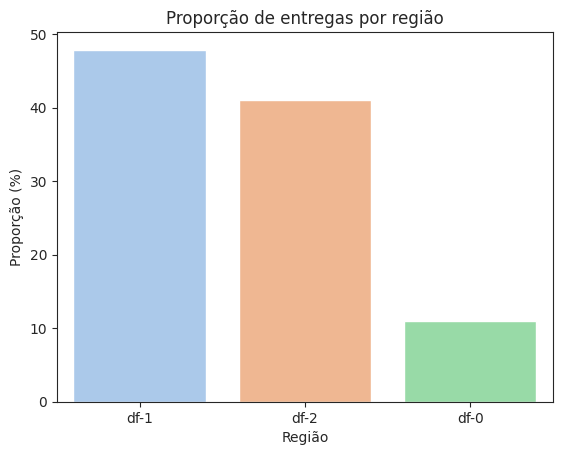

In [69]:
data = deliveries_df['region'].value_counts(normalize=True).reset_index()
data.columns = ['region', 'region_percent']
data['region_percent'] *= 100  # Converte para porcentagem

with sns.axes_style('ticks'):
    grafico = sns.barplot(data=data, x='region', y='region_percent', hue='region', palette='pastel', legend=False)
    grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção (%)')

plt.show()

**Insights**:

* Ao analisar as proporções de entregas por HUB, identificamos oportunidades de melhoria. O HUB DF-0 possui uma baixa taxa de entrega, sugerindo potencial para melhor atender às regiões administrativas 1, 3, 12 e 24. Além disso, devido à densidade populacional, as regiões 3 e 28 oferecem oportunidades de crescimento adicionais para o DF-0. Por outro lado, o HUB DF-1 mostra potencial em áreas com alta demanda, como as regiões 6, 17 e 18. Essas observações podem guiar estratégias de otimização e expansão para ambos os HUB's.